In [1]:
from akd.tools.search import (
    SearxNGSearchTool,
    SearxNGSearchToolConfig,
    SearxNGSearchToolInputSchema
)
import pprint

In [2]:
SEARCH_TOOL = SearxNGSearchTool(
    config=SearxNGSearchToolConfig(
        base_url="http://localhost:8080",
        max_results=5,
        engines=["google", "arxiv", "google_scholar"],
        debug=True
    )
)

In [3]:
QUERY= "what are methods for estimating the economic impacts of landslides in Nepal"
result = await SEARCH_TOOL.arun(
    SearxNGSearchToolInputSchema(queries=[QUERY])
)

2025-05-30 19:31:01.456 | DEBUG    | akd.tools.search:_fetch_search_results_paginated:262 - Fetching page 1 for query: what are methods for estimating the economic impacts of landslides in Nepal
2025-05-30 19:31:03.218 | DEBUG    | akd.tools.search:_fetch_search_results_paginated:271 - Fetched 30 results for page 1
2025-05-30 19:31:03.321 | DEBUG    | akd.tools.search:_fetch_search_results_paginated:262 - Fetching page 2 for query: what are methods for estimating the economic impacts of landslides in Nepal
2025-05-30 19:31:05.754 | DEBUG    | akd.tools.search:_fetch_search_results_paginated:271 - Fetched 30 results for page 2
2025-05-30 19:31:05.856 | DEBUG    | akd.tools.search:_fetch_search_results_paginated:290 - Fetched 24 results across 2 pages for query: what are methods for estimating the economic impacts of landslides in Nepal
2025-05-30 19:31:05.857 | DEBUG    | akd.tools.search:arun:345 - [{'template': 'paper.html', 'type': '', 'url': 'https://infohub.practicalaction.org/bits

In [4]:
print(len(result.results))
print(result.results[0].model_dump().keys())

10
dict_keys(['url', 'pdf_url', 'title', 'content', 'query', 'category', 'doi', 'published_date', 'engine', 'tags', 'extra', 'title_augmented'])


In [5]:
pprint.pprint(result.results[0].model_dump())

{'category': 'science',
 'content': '… -economic effects of landslides to the particular locality. '
            'Landslide has more broader and indirect impacts, … was to assess '
            'the economic impacts of landslides. Specific objectives include: '
            '…',
 'doi': None,
 'engine': 'google scholar',
 'extra': {'authors': ['A Consultancy', 'PAS Asia'],
           'comments': '',
           'engines': ['google scholar'],
           'html_url': None,
           'img_src': '',
           'journal': None,
           'parsed_url': ['https',
                          'infohub.practicalaction.org',
                          '/bitstream/handle/11283/550259/Technical%20report.pdf',
                          '',
                          'sequence=1',
                          ''],
           'positions': [1],
           'priority': '',
           'publisher': None,
           'score': 1.0,
           'template': 'paper.html',
           'thumbnail': '',
           'type': ''}

In [6]:
from deepeval.metrics.dag import (
    DeepAcyclicGraph,
    TaskNode,
    BinaryJudgementNode,
    NonBinaryJudgementNode,
    VerdictNode,
)
from typing import List, Optional
from deepeval.metrics.dag.nodes import BaseNode, decrement_indegree, construct_node_verbose_log
from deepeval.metrics.base_metric import BaseMetric
from deepeval.test_case import LLMTestCase, LLMTestCaseParams

from deepeval.metrics.dag import (
    DeepAcyclicGraph,
    TaskNode,
    BinaryJudgementNode,
    NonBinaryJudgementNode,
    VerdictNode,
)
import json


class CustomTaskNode(TaskNode):
    """
    Custom TaskNode that executes a task and generates output based on the provided
    evaluation parameters and parents.
    """

    output_label: str
    children: List[BaseNode]
    instructions:str = ""
    evaluation_params: List[LLMTestCaseParams] = None
    label: Optional[str] = None
    _verbose_logs: Optional[str] = None
    _output: Optional[str] = None
    _parents: Optional[List[BaseNode]] = None

    def __init__(
            self, 
            output_label: str,
            custom_task: callable,
            children: List[BaseNode],
            instructions: str = "",
            evaluation_params: List[LLMTestCaseParams] = None,
            label: Optional[str] = None,
            _verbose_logs: Optional[str] = None,
            _output: Optional[str] = None,
            _parents: Optional[List[BaseNode]] = None
        ):
            super().__init__(
                instructions="", 
                output_label = output_label, 
                children=children,
                evaluation_params=evaluation_params,
                label=label,
                _verbose_logs=_verbose_logs,
                _output=_output,
                _parents=_parents,
                
            )
            self.custom_task = custom_task
      

    def _execute(self, metric: BaseMetric, test_case: LLMTestCase, depth: int):
            self._depth = max(0, self._depth, depth)
            decrement_indegree(self)
            if self._indegree > 0:
                return
            
            
            params = {param_name: getattr(test_case, param_name) for param_name in self.evaluation_params}
                 

            result = self.custom_task(**params)
            self._output = str(result)

            metric._verbose_steps.append(
                construct_node_verbose_log(self, self._depth)
            )


            for children in self.children:
                children._execute(
                    metric=metric, test_case=test_case, depth=self._depth + 1
                )

novel_insights_node = BinaryJudgementNode(
      criteria="Does the content offer information, arguments, or perspectives that are likely new or non-obvious to the user?", 
      children= [
          VerdictNode(verdict = False, score=0),
          VerdictNode(verdict = True, score=5, child=None)
      ]
)
    
usefullness_of_content_node = BinaryJudgementNode(
    criteria="Does the content of the paper/set of papers directly address the primary research question or topic?", 
    children = [
        VerdictNode(verdict = False, score=0),
        VerdictNode(verdict = True, score=5, child= None)
    ]
)


extract_content_node = CustomTaskNode(
    output_label = "paper_content", 
    instructions = "",
    custom_task = lambda result: json.loads(result)["content"],
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT],
    children = [usefullness_of_content_node, novel_insights_node],
    label="Extract content from search results",
)

dag = DeepAcyclicGraph(root_nodes=[extract_content_node])

In [7]:
from deepeval.metrics import DAGMetric

result_eval = DAGMetric(name="Evaluate quality of search result", dag=dag, verbose_mode=True)

test_case = LLMTestCase(input=QUERY, actual_output=result.results[0].model_dump())

result_eval.measure(test_case)
print(result_eval.score)
print(result_eval.reason)

Output()

**************************************************

Evaluate quality of search result (DAG) Verbose Logs

**************************************************

______________________
| TaskNode | Level == 0 |
*******************************
Label: Extract content from search results

Instructions:


paper_content:
The technical report on economic impact of landslides in Nepal, published in 2015, provides methods for estimating 
the economic impacts of landslides. The specific objectives include assessing the economic effects of landslides to
a particular locality and understanding the broader and indirect impacts of landslides.
 
 
__________________________________
| BinaryJudgementNode | Level == 1 |
************************************************
Label: None

Criteria:
Does the content of the paper/set of papers directly address the primary research question or topic?

Verdict: False
Reason: The paper does not directly address the primary research question or topic as it focuses on estimating the 
economic impacts of landslides in Nepal and understanding their broader and indirect impacts, rather than 
addressing a specific primary research question or topic.
 
 
________________________
| VerdictNode | Level == 2 |
**********************************
Verdict: False
Type: Deterministic 
 
__________________________________
| BinaryJudgementNode | Level == 1 |
************************************************
Label: None

Criteria:
Does the content offer information, arguments, or perspectives that are likely new or non-obvious to the user?

Verdict: False
Reason: The content does not offer new or non-obvious information, arguments, or perspectives to the user. It 
simply states that a technical report on economic impact of landslides in Nepal was published in 2015 and provides 
methods for estimating the economic impacts of landslides.
 
 
________________________
| VerdictNode | Level == 2 |
**********************************
Verdict: False
Type: Deterministic
 
Score: 0.0
Reason: The score for the metric 'Evaluate quality of search result (DAG)' is 0.0 because the content of the paper 
does not directly address the primary research question or topic, and it does not offer new or non-obvious 
information, arguments, or perspectives to the user.

======================================================================

0.0
The score for the metric 'Evaluate quality of search result (DAG)' is 0.0 because the content of the paper does not directly address the primary research question or topic, and it does not offer new or non-obvious information, arguments, or perspectives to the user.


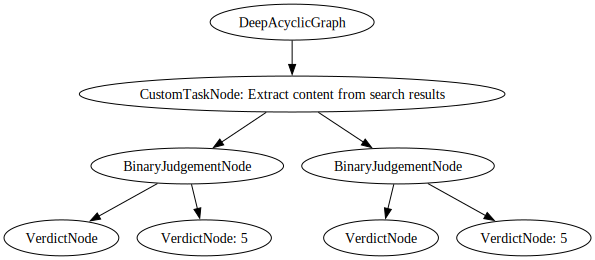

In [8]:
from graphviz import Digraph

def visualize_dag(root, get_label=lambda node: str(node)):
    """
    Visualize a DAG given a root node.
    - root: the root node of the DAG
    - get_label: function to get a label for each node (default: str(node))
    """
    dot = Digraph()
    visited = set()


    def add_edges(node):
        node_id = id(node)
        if node_id in visited:
            return

        dot.node(str(node_id), get_label(node))
        
        root_nodes = getattr(node, "root_nodes", None)
        if root_nodes:
            for root in root_nodes:
                dot.edge(str(node_id), str(id(root)))
                add_edges(root)
        
        # Handle 'child' (single node)
        child = getattr(node, "child", None)
        
        if child is not None:
            dot.edge(str(node_id), str(id(child)))
            add_edges(child)
        
        
        # Handle 'children' (list of nodes)
        children = getattr(node, "children", None)
        if children:
            for c in children:
                dot.edge(str(node_id), str(id(c)))
                add_edges(c)

    add_edges(root)
    return dot

def _get_label(node): 
    label = getattr(node, "label", getattr(node, "score", ""))
    label = f": {str(label)}" if label else ""
    return f"{node.__class__.__name__}{label}"
dot = visualize_dag(dag, get_label=_get_label)
dot  # This will render the graph inline